# Local Return Periods

One question of interest is what the return period is for *local* cold extremes.
In other words, how rare was the 2021 cold outbreak at different points?
Understanding local return periods for cold weather can tell us about how surprised buildings and other facilities should have been by the cold they experienced.

We will use two data sets:

1. The GHCND data set: this is station data
1. The ERA5 reanalysis data set: this uses a climate model to assimilate not only temperature data but also other sources of data, and produces a data set that is consistent with the laws of physics.

These data sets can diverge because

1. Point data is different from a grid average
1. The ERA5 data is air temperature at 2m, which is not exactly the same as the surface
1. Potential bias in data sets
1. ERA5 assimilates other sources of data.

Thus, findings that are consistent across the two data sets are relatively likely to be credible

In [1]:
import os

import cartopy.crs as ccrs
from cartopy.feature import STATES, COASTLINE
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import regionmask
import numpy as np
import pandas as pd
import xarray as xr

from codebase.calc import return_period as calc_return_period
from codebase.data import PARDIR, get_ghcn_data
from codebase.read_ghcn import read_station_metadata
from codebase.fig import figname

## GHCND

We start with the GHCND data

First, load the data set in which we computed the empirical exceedance probability for annual-maximum cold outbreaks of different lengths.
This is just the number of years in which there was a cold outbreak, divided by the number of years in the data set

In [2]:
return_period = 1 / pd.read_csv(os.path.join(PARDIR, "data", "processed", "ghcnd_exceedances.csv"), index_col=0)

Now we join this with station information

In [3]:
metadata = read_station_metadata(os.path.join(PARDIR, "data", "raw", "ghcnd_stations.txt"))
mrg = return_period.join(metadata[["LATITUDE", "LONGITUDE", "NAME"]], how="left")
mrg.head()

,temp_1_days,temp_2_days,temp_3_days,temp_4_days,LATITUDE,LONGITUDE,NAME
USC00410493,41.311906,83.655276,81.382985,95.029496,31.7414,-99.9764,BALLINGER 2 NW
USC00410586,8.173879,11.021397,14.786247,16.554903,29.9142,-94.9908,BAYTOWN
USC00410639,29.392133,37.567606,89.779637,60.214116,28.4575,-97.7061,BEEVILLE 5 NE
USC00410902,30.897067,54.896505,49.514420,53.436562,29.7986,-98.7353,BOERNE
USC00411128,60.798049,39.059982,33.020805,41.457798,33.1908,-102.2681,BROWNFIELD #2


Here are all the stations we are using:

In [4]:
mrg["NAME"].values

array(['BALLINGER 2 NW', 'BAYTOWN', 'BEEVILLE 5 NE', 'BOERNE',
       'BROWNFIELD #2', 'BROWNWOOD 2ENE', 'BURNET', 'CARRIZO SPRINGS 3S',
       'CARTHAGE', 'CHISOS BASIN', 'CORSICANA', 'CROCKETT', 'CROSBYTON',
       'DANEVANG 1 W', 'FLOYDADA', 'FOLLETT', 'GATESVILLE',
       'HALLETTSVILLE 2 N', 'HASKELL', 'HUNTSVILLE', 'JACKSBORO',
       'LEVELLAND', 'MARSHALL', 'MATADOR', 'MEMPHIS', 'MT PLEASANT',
       'MULESHOE #1', 'PANTHER JUNCTION', 'PARIS', 'PLAINS', 'PLAINVIEW',
       'RAYMONDVILLE', 'ROSCOE', 'SEMINOLE', 'SHERMAN', 'SNYDER',
       'SULPHUR SPRINGS', 'TAHOKA', 'TULIA', 'WEATHERFORD', 'WILLS PT',
       'COLLEGE STN', 'DALLAS FT WORTH AP', 'PORT ARTHUR SE TX AP',
       'HOUSTON HOBBY AP', 'SAN ANTONIO INTL AP', 'CORPUS CHRISTI',
       'CORPUS CHRISTI NAS', 'KINGSVILLE NAAS', 'AUSTIN-CAMP MABRY',
       'WACO RGNL AP', 'DALLAS LOVE FLD', 'ABILENE RGNL AP',
       'WICHITA FALLS MUNI AP', 'CHILDRESS MUNI AP', 'MIDLAND ODESSA',
       'SAN ANGELO', 'WINKLER CO AP', 'LUBBOCK

Now we can plot the data

In [5]:
durations_plot = [1, 2, 3, 4]
data_proj = ccrs.PlateCarree()
map_proj = ccrs.LambertConformal()

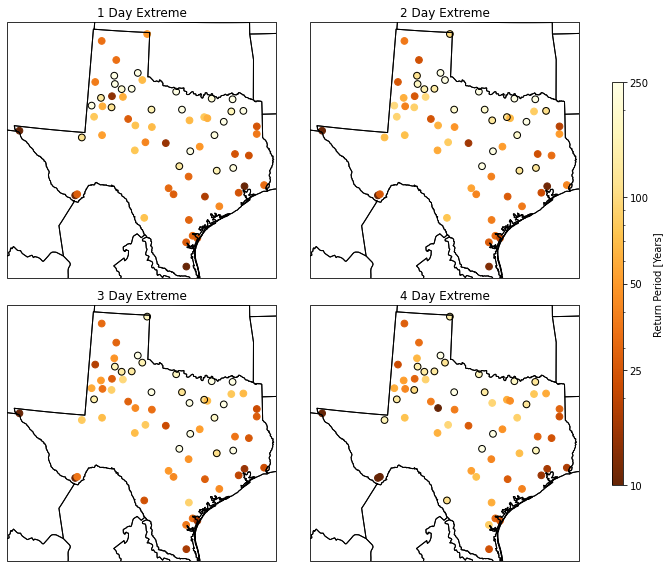

In [6]:
VMAX = 250 # color bar limit
VMIN = 10
TICKS = [VMIN, 25, 50, 100, VMAX]

fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={"projection": map_proj}, figsize=(10, 8))
for ax, dur in zip(axes.flat, durations_plot):
    # scatter plot
    sc = ax.scatter(
        mrg["LONGITUDE"],
        mrg["LATITUDE"],
        c=mrg[f"temp_{dur}_days"],
        norm=colors.LogNorm(VMIN, VMAX),
        transform=data_proj,
        cmap="YlOrBr_r",
        s=45,
    )
    outliers = mrg.loc[mrg[f"temp_{dur}_days"] > 100] # highlight any stations outside the boundaries
    ax.scatter(
        outliers["LONGITUDE"],
        outliers["LATITUDE"],
        transform=data_proj,
        facecolors="none",
        edgecolors="black",
        s=45,
    )
    ax.set_title(f"{dur} Day Extreme")
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)

fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax = cax, label="Return Period [Years]")
cbar.set_ticks(TICKS)
cbar.ax.set_yticklabels(TICKS)
plt.savefig(figname("local_rt_ghcnd.pdf"))
plt.show()

Note that here a circle means it was a >=100 year return period event.

Because I live in Houston and I'm curious, what was the return period at Hobby?

In [7]:
mrg.loc[lambda df: df["NAME"] == "HOUSTON HOBBY AP"]

,temp_1_days,temp_2_days,temp_3_days,temp_4_days,LATITUDE,LONGITUDE,NAME
USW00012918,24.413548,22.109533,20.446919,15.326836,29.6381,-95.2819,HOUSTON HOBBY AP


About a 1 in 25 year storm at Hobby!
I guess I should more cold weather here in Houston...

## ERA5

Let's also create the same plot using our (gridded) ERA5 estimates

In [8]:
era5_rt = (
    xr.open_dataarray("../data/processed/era5/exceedance.nc").
    sel(latitude=slice(37, 27), longitude=slice(-106, -92)).
    rename({"longitude": "lon", "latitude": "lat"}) # rename to work w/ regionmask
)

We want to plot only over land

In [9]:
countries = regionmask.defined_regions.natural_earth.countries_110
mask = countries.mask(era5_rt)
usa_idx = countries.map_keys("United States of America")
mexico_idx = countries.map_keys("Mexico")
rt_land = era5_rt.where(np.logical_or(mask == usa_idx, mask == mexico_idx))

These estimates have already been calculated

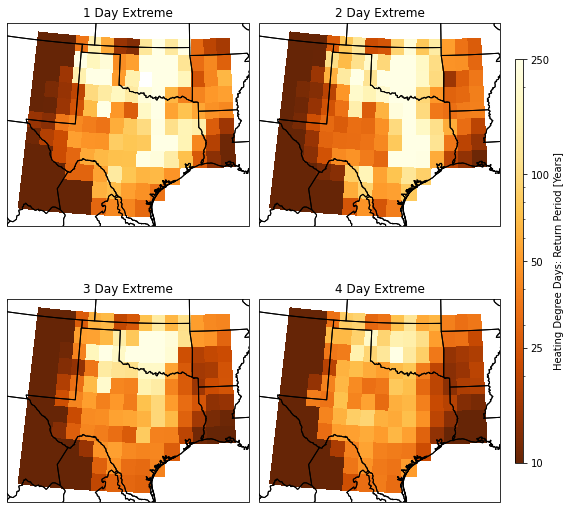

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={"projection": map_proj}, figsize=(8, 8))

for ax, dur in zip(axes.flat, era5_rt["lag"].values):
    rt_land.sel(lag=dur).plot(
        ax=ax,
        norm=colors.LogNorm(VMIN, VMAX),
        transform=data_proj,
        cmap="YlOrBr_r",
        add_colorbar=False,
    )
    ax.set_title(f"{dur} Day Extreme")
    ax.add_feature(STATES)
    ax.add_feature(COASTLINE)

fig.canvas.draw()
fig.tight_layout()
fig.subplots_adjust(right=0.875)
cax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
cbar = fig.colorbar(sc, cax = cax, label="Heating Degree Days: Return Period [Years]")
cbar.set_ticks(TICKS)
cbar.ax.set_yticklabels(TICKS)
plt.savefig(figname("local_rt_era5.pdf"))
plt.show()

We can see that our findings are generally consistent across these two very different datasets, which adds credibility.